In [3]:
import pandas as pd
import numpy as np

In [11]:

master = []
for year in range(2007, 2023):
    skaters = pd.read_csv(f'cleaned/{year}{year+1}_skaters.csv', encoding='utf-8')
    skaters['Season'] = str(year) + str(year+1)
    skaters['Player'] = skaters['Player'].str.replace('\xa0', ' ')
    skaters['Player'] = skaters['Player'].str.replace('Tim Stützle', 'Tim Stutzle')
    skaters['Player'] = skaters['Player'].str.replace('Alexis Lafrenière', 'Alexis Lafreniere')

    skaters['Date'] = skaters['Date'].str.replace('/', '-')
    skaters.to_csv(f'cleaned/{year}{year+1}_skaters.csv')
    master.append(skaters)
skaters['Season'] = skaters['Season'].astype(object)
skaters = pd.concat(master)
skaters = skaters.reset_index(drop=True)
skaters.to_csv('cleaned/master_skaters.csv', encoding='utf-8')

In [4]:
skaters = pd.read_csv(f'cleaned/master_skaters.csv')
skaters['exGF'] = skaters['TOI']*0.032+0.055
skaters['exGA'] = skaters['TOI']*0.032+0.055
skaters['eGF'] = skaters['TOI']*0.032+0.055
skaters['eGA'] = skaters['TOI']*0.032+0.055
skaters['GFAA'] = skaters['GF'] - skaters['eGF']
skaters['GAAA'] =  skaters['eGA'] - skaters['GA']
skaters['xGFAA'] = skaters['xGF'] - skaters['exGF']
skaters['xGAAA'] =  skaters['exGA'] - skaters['xGA']
skaters['Production'] = (0.75*skaters['Goals']) + (0.7*skaters['First Assists']) + (0.55*skaters['Second Assists']) + (0.5*skaters['ixG']) + (0.05*skaters['Shots Blocked']) 
skaters['Misc'] = (0.15*(skaters['Penalties Drawn'] - skaters['Total Penalties'])) + (0.01*(skaters['Faceoffs Won'] - skaters['Faceoffs Lost']))
skaters['Offense'] = np.where(skaters['Position'] == 'D', 
((0.425*(skaters['GF'] + skaters['GFAA'])) + (1.7*(skaters['xGF'] + skaters['xGFAA'])))/2.125 - 0.75,
(((0.625*(skaters['GF'] + skaters['GFAA'])) + (0.625*(skaters['xGF'] + skaters['xGFAA'])))/2) - 0.4)
skaters['Defense'] = np.where(skaters['Position'] == 'D', 
(((0.575*(-skaters['GA'] + skaters['GAAA'])) + (2.3*(-skaters['xGA'] + skaters['xGAAA'])))/2) + 1.05, 
(((0.4375*(-skaters['GA'] + skaters['GAAA'])) + (1.7*(-skaters['xGA'] + skaters['xGAAA'])))/2) + 0.6)
skaters['Score'] = skaters['Production'] + skaters['Misc'] + skaters['Offense'] + skaters['Defense']
skaters = skaters.loc[:, ~skaters.columns.str.contains('^Unnamed')]
births = pd.read_csv('birthdates.csv')

merged = skaters.merge(births[['Player', 'Season', 'dob']], how='left', on=['Player', 'Season'])
merged['dob'] = np.where(((merged.Player == 'Sebastian Aho') & (merged.Team == 'New York Islanders')),'1999-07-26', merged['dob'])
merged['dob'] = np.where(((merged.Player == 'Sebastian Aho') & (merged.Team != 'New York Islanders')),'1996-02-17', merged['dob'])
merged[["Date", "dob"]] = merged[["Date", "dob"]].apply(pd.to_datetime)
merged['Age'] = (merged["Date"] - merged["dob"]).dt.days/365



In [ ]:
goalies = pd.read_csv(f'cleaned/master_goalies.csv')
goalies['Score'] = goalies['Expected Goals Against'] - goalies['Goals Against']
goalies.sort_values(by='Score', ascending=False)

In [7]:
import unidecode
lst = []
for year in range(2007, 2022):
    output = tdhepscrape.get_skaters("nhl", f"{year}-{year+1}")
    results = tdhepscrape.add_player_information(output)
    results['season'] = str(year) + str(year+1)
    condensed = results[['player', 'season', 'team', 'dob']]
    lst.append(condensed)

births = pd.concat(lst)
births[['player','pos']] = births['player'].str.split('( ',expand=True)
births['pos'] = births['pos'].str.replace(')', '')
births['Team'] = births['Team'].str.replace('.', '')
births['Player'] = births['Player'].str.replace('Alex ', 'Alexander ')
births['Player'] = births['Player'].str.replace('Yevgeni ', 'Evgeni ')

decoded = [unidecode.unidecode(e) for e in births['player']]
births['player'] = decoded
births = births.rename(columns={'player':'Player', 'team':'Team', 'season':'Season'})

NameError: name 'tdhepscrape' is not defined

In [105]:
import plotly.graph_objects as go
import numpy as np
from moepy import lowess
def get_test_projections(alpha):
    player = 'Tage Thompson'
    df = merged[merged.Player == player]
    df = df.sort_values(by='Date')
    df['Career Game'] = range(1, len(df) + 1)
    df[["Date", "dob"]] = df[["Date", "dob"]].apply(pd.to_datetime)
    projections = [0]
    scores = df['Score'].to_list()
    total = 0

    for i in range(1, len(df)):
        curr = 0

        j = i-1
        if j >= 0:

            weight = alpha**(df['Date'].to_list()[i] - df['Date'].to_list()[j]).days
        else:
            weight = alpha**(-1*j)
        
        curr += weight * projections[-1] * total
        curr += weight * scores[j]
        total += 1
        total *= weight
        projections.append((curr/total))            

        

    df['Projection'] = projections           

        

    df['Projection'] = projections
    df['Error'] = df['Projection'] - df['Score']
    df['AError'] = abs(df['Error'])

    return df['AError'].mean()


In [130]:
import numpy as np

def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=100):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, fitness[best_idx]

In [142]:
it = list(de(lambda x: get_test_projections(x), bounds=[(0.99, 1)]))
print(it[-1])

(array([0.99809326]), array([0.96051178]))


In [43]:
import plotly.graph_objects as go
import numpy as np
from moepy import lowess
from collections import namedtuple
import pickle
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
from scipy.stats import norm
from datetime import datetime
start_dates = {season: datetime.strptime((str(season)[:4] + '-10-04'), '%Y-%m-%d') for season in skaters.groupby(['Season']).count().index}
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def get_projections(player, time_type):
    alpha = 0.99809326
    df = merged[merged.Player == player]
    df = df.sort_values(by='Date')
    df['Career Game'] = range(1, len(df) + 1)
    df['Adjusted'] = df['Score']*(50/1.55) + 50
    df[["Date", "dob"]] = df[["Date", "dob"]].apply(pd.to_datetime)
    projections = [0]
    scores = np.concatenate((np.zeros(10),  df['Score'].to_list()))
    total = 0

    for i in range(-9, len(df)):
        curr = 0

        j = i-1
        if j >= 0:

            weight = alpha**(df['Date'].to_list()[i] - df['Date'].to_list()[j]).days
        else:
            weight = alpha**(-1*j)
        
        curr += weight * projections[-1] * total
        curr += weight * scores[j+10]
        total += 1
        total *= weight
        projections.append((curr/total))            

        

    df['Projection'] = projections[10:]



    sensor_var = 1.3330171065772254
    process_var = 0.0013513089896074557
    process_model = gaussian(0., process_var)
    pos = gaussian(0., 100.)
    N = len(df) + 10
    zs = np.concatenate((np.zeros(10), df['Score'].to_list()))
    ps = []
    for i in range(N):
        prior = predict(pos, process_model)    
        pos = update(prior, gaussian(zs[i], sensor_var))
        ps.append(pos.mean)
    df['Kalman'] = ps[10:]

    # load the dataset
    series = df[['Projection', 'Kalman']]
    values = series.values

    # fit model
    model = pickle.load(open('finalized_model.sav', 'rb'))
    # construct an input for a new preduction
    preds = df['Kalman'].to_list()[:82]
    for i in range(82, len(df)):
        row = values[i-82:i].flatten()
    # make a one-step prediction
        yhat = model.predict(asarray([row]))
        preds.append(yhat[0])
    df['XGB'] = preds

    ages = range(18, 48)
    A = [-0.14396,-0.05957,0.021176,0.080782,0.144998,0.176731,
            0.181012,0.179595,0.162485,0.137085,0.114395,0.094328,
            0.071203,0.043198,0.013411,0.002706,-0.01087,-0.030415,
            -0.04996,-0.03732,-0.06303,-0.03521,-0.038033904,-0.033721952,
            -0.02941,-0.04036,-0.05131,-0.08806,-0.08892,-0.08978]
    poly  = np.polyfit(ages, A, 4)
    for i in range(1, len(preds)):
        prev_age = df['Age'].to_list()[i-1]
        prev_expected = np.polyval(poly, prev_age)
        curr_expected = np.polyval(poly, df['Age'].to_list()[i])
        multiplier = curr_expected/prev_expected
        if preds[i] < 0:
            preds[i] = preds[i]/multiplier
        else:
            preds[i] = preds[i] * multiplier



    for i in range(0, len(df)):
        season = df['Season'].to_list()[i]
        since_start = (df['Date'].to_list()[i] - start_dates[season]).days
        season_adjust = (-0.00109 * since_start  + 1.1)
        if df['Venue'].to_list()[i] == 'Home':
            preds[i] = preds[i]*1.35*season_adjust*1.2
        else:
            preds[i] = preds[i]*1.35*season_adjust*0.8


        prev = merged[(merged.Season == season) & (merged.Date < df['Date'].to_list()[i])]
        opps = prev.groupby(['Opposition']).mean(numeric_only=True)[['Score']]
        opps['Multiplier'] = (opps['Score']+5)/5.438829866884756
        mult = opps[opps.index == (df['Opposition'].to_list()[i])]['Multiplier']
        if len(mult) > 0:
            mult = mult[0]
        else:
            mult = 1
        preds[i] = preds[i] * mult

    df['adjXGB'] = preds
      
    # Model fitting
    frac = 0.25
    quant_reg_func = lowess.calc_quant_reg_betas
    quantile_model = lowess.Lowess(reg_func=quant_reg_func)
    quantile_model.fit(np.asarray(df[time_type]), np.asarray(df['XGB']), frac=frac, q=0.5, robust_iters=3)
    df_quantiles = lowess.quantile_model(np.asarray(df[time_type]), np.asarray(df['XGB']), frac=frac, num_fits=20, robust_iters=3)
    df['XGB_Lowess'] = df_quantiles[0.5].to_list()

    quant_reg_func = lowess.calc_quant_reg_betas
    quantile_model = lowess.Lowess(reg_func=quant_reg_func)
    quantile_model.fit(np.asarray(df[time_type]), np.asarray(df['adjXGB']), frac=frac, q=0.5, robust_iters=3)
    df_quantiles = lowess.quantile_model(np.asarray(df[time_type]), np.asarray(df['adjXGB']), frac=frac, num_fits=20, robust_iters=3)
    df['adjXGB_Lowess'] = df_quantiles[0.5].to_list()
    pots = []
    mults = []
    for i in range(0, len(df)):
        curr_age = df['Age'].to_list()[i]
        if curr_age <= 24.26795064:
            curr_expected = np.polyval(poly, curr_age)
            multiplier = (0.37233423)/(curr_expected+0.2)
            mults.append(multiplier)
            if df['XGB_Lowess'].to_list()[i] < 0:
                pots.append(df['XGB_Lowess'].to_list()[i]/multiplier)
            else:
                pots.append(df['XGB_Lowess'].to_list()[i]  * multiplier)

        elif curr_age <= 38.62152643:
            mults.append(1)

            pots.append(df['XGB_Lowess'].to_list()[i] )
        elif curr_age <= 42.25458411:
            curr_expected = np.polyval(poly, curr_age)
            multiplier = 0.24220954/(curr_expected+0.2)
            mults.append(multiplier)

            if df['XGB_Lowess'].to_list()[i] < 0:
                pots.append(df['XGB_Lowess'].to_list()[i]/multiplier)
            else:
                pots.append(df['XGB_Lowess'].to_list()[i]  * multiplier)        
        else:
            mults.append(1)

            pots.append(df['XGB_Lowess'].to_list()[i] )
    df['multiplier'] = mults
    df['Potential'] = pots
    df.reset_index(inplace=True, drop=True)
    df_quantiles.reset_index(inplace=True, drop=True)
    return df, df_quantiles



In [46]:
players = list(merged[merged.Season == 20222023].Player.unique())
players.sort()
recents = []
errors = []
for player in players[:300]:
    print(player)
    try:
        df = pd.read_csv('projections/20222023/'+(player.replace(' ', '_'))+'.csv')
    except:
        df, df_quantiles = get_projections(player, 'Career Game')
        df.to_csv('projections/20222023/'+(player.replace(' ', '_'))+'.csv')
        recents.append(df[df.index == len(df)-1])

A.J. Greer
Aaron Ekblad
Aatu Raty
Adam Beckman
Adam Boqvist
Adam Erne
Adam Fox
Adam Henrique
Adam Larsson
Adam Lowry


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


Adam Pelech


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Adam Ruzicka


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Adrian Kempe


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Alec Martinez


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


Alec Regula


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Aleksander Barkov


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Aleksi Heponiemi


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Alex Barré-Boulet


100%|██████████| 9/9 [00:17<00:00,  1.93s/it]


Alex Belzile


100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


Alex Chiasson


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Alex DeBrincat


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Alex Galchenyuk


100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


Alex Goligoski


100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


Alex Iafallo


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Alex Killorn


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Alex Newhook


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Alex Nylander


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Alex Ovechkin


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Alex Pietrangelo


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Alex Steeves


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Alex Tuch


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Alex Turcotte


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


Alex Wennberg


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Alexander Alexeyev


100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


Alexander Barabanov


100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


Alexander Edler


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Alexander Holtz


100%|██████████| 9/9 [00:17<00:00,  1.92s/it]


Alexander Kerfoot


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


Alexander Romanov


100%|██████████| 9/9 [00:04<00:00,  2.06it/s]


Alexandre Carrier


100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


Alexey Toropchenko


100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


Alexis Lafreniere


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Aliaksei Protas


100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


Anders Bjork


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


Anders Lee


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


Andre Burakovsky


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Andreas Athanasiou


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Andreas Englund


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Andreas Johnsson


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Andrei Kuzmenko


100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Andrei Svechnikov


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


Andrew Agozzino


100%|██████████| 9/9 [00:17<00:00,  1.91s/it]


Andrew Cogliano


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


Andrew Copp


100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


Andrew Mangiapane


100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Andrew Peeke


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Andy Andreoff


100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Anthony Beauvillier


100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Anthony Cirelli


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


Anthony Duclair


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Anthony Mantha


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Anthony Richard


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Anton Blidh


100%|██████████| 9/9 [00:04<00:00,  2.07it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Anton Levtchi


100%|██████████| 9/9 [00:00<00:00, 17.60it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.33it/s]


Anton Lundell


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Anton Stralman


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


Anze Kopitar


100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


Arber Xhekaj


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Arnaud Durandeau


c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.20it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 20.77it/s]


Artem Zub


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Artemi Panarin


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Arthur Kaliyev


100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Artturi Lehkonen


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Austin Czarnik


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Austin Strand


100%|██████████| 9/9 [00:03<00:00,  2.35it/s]


Austin Watson


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Auston Matthews


100%|██████████| 9/9 [00:04<00:00,  1.94it/s]


Axel Jonsson-Fjallby


100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


Barclay Goodrow


100%|██████████| 9/9 [00:03<00:00,  2.27it/s]


Barrett Hayton


100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Beck Malenstyn


100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


Ben Chiarot


100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Ben Harpur


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Ben Hutton


100%|██████████| 9/9 [00:06<00:00,  1.50it/s]


Ben Meyers


100%|██████████| 9/9 [00:03<00:00,  2.50it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Billy Sweezey


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 17.19it/s]


Blake Coleman


100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Blake Lizotte


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Blake Wheeler


100%|██████████| 9/9 [00:04<00:00,  2.08it/s]


Bo Horvat


100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


Bobby McMann


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Bokondji Imama


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


Boone Jenner


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Boris Katchouk


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Bowen Byram


100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Brad Hunt


100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


Brad Malone


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Brad Marchand


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


Braden Schneider


100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


Brady Skjei


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


Brady Tkachuk


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Brandon Carlo


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Brandon Duhaime


100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


Brandon Hagel


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


Brandon Montour


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Brandon Saad


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Brandon Tanev


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Brandt Clarke


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


Brayden McNabb


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Brayden Pachal


100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Brayden Point


100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


Brayden Schenn


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Brendan Gallagher


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Brendan Gaunce


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Brendan Lemieux


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Brendan Smith


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Brenden Dillon


100%|██████████| 9/9 [00:04<00:00,  2.25it/s]


Brent Burns


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


Brett Howden


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


Brett Kulak


100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


Brett Leason


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Brett Pesce


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Brett Ritchie


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Brett Seney


100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Brian Dumoulin


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Brock Boeser


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Brock McGinn


100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Brock Nelson


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


Bryan Rust


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Buddy Robinson


100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


Byron Froese


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


CJ Suess


100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


Cal Clutterbuck


100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


Cal Foote


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Cale Fleury


100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Cale Makar


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Caleb Jones


100%|██████████| 9/9 [00:04<00:00,  2.07it/s]


Calen Addison


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Callahan Burke


100%|██████████| 9/9 [00:00<00:00, 14.81it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 21.37it/s]


Calle Jarnkrok


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


Calle Rosen


100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


Calvin de Haan


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Cam Fowler


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Cam York


100%|██████████| 9/9 [00:03<00:00,  2.35it/s]


Carl Grundstrom


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


Carson Meyer


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


Carson Soucy


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


Carter Verhaeghe


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Casey Cizikas


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Casey Fitzgerald


100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Casey Mittelstadt


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Chad Ruhwedel


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Chandler Stephenson


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Charles Hudon


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Charlie Coyle


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Charlie McAvoy


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


Chris Kreider


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


Chris Tanev


100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


Chris Tierney


100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


Chris Wagner


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Chris Wideman


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Christian Dvorak


100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


Christian Fischer


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


Christian Wolanin


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


Claude Giroux


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Clayton Keller


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Cody Ceci


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


Cody Glass


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Cole Bardreau


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


Cole Caufield


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Cole Guttman


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Cole Koepke


100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


Cole Perfetti


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


Cole Sillinger


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Cole Smith


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


Colin Blackwell


100%|██████████| 9/9 [00:04<00:00,  2.06it/s]


Colin Miller


100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


Colin White


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Colton Parayko


100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Colton Sissons


100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


Colton White


100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Connor Brown


100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


Connor Clifton


100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


Connor Dewar


100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Connor Mackey


100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


Connor McDavid


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


Connor McMichael


100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


Connor Murphy


100%|██████████| 9/9 [00:04<00:00,  2.06it/s]


Conor Garland


100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


Conor Sheary


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Conor Timmins


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Corey Perry


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Corey Schueneman


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Craig Smith


100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Curtis Lazar


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Dakota Joshua


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Dakota Mermis


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


Damon Severson


100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


Dan Renouf


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Daniel Sprong


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Daniil Miromanov


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Dante Fabbro


100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Danton Heinen


100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


Darnell Nurse


100%|██████████| 9/9 [00:03<00:00,  2.35it/s]


Darren Helm


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Darren Raddysh


100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


David Gust


c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.22it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


David Gustafsson


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



David Jiricek


100%|██████████| 9/9 [00:00<00:00, 18.50it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 22.23it/s]


David Kampf


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


David Krejci


100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


David Pastrnak


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


David Perron


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


David Savard


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Dawson Mercer


100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


Denis Gurianov


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Denis Malgin


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Dennis Cholowski


100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


Dennis Gilbert


100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


Derek Forbort


100%|██████████| 9/9 [00:04<00:00,  2.07it/s]


Derek Grant


100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Derek Ryan


100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


Derek Stepan


100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


Derick Brassard


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Derrick Pouliot


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


Devin Shore


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Devon Toews


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


Dillon Dube


100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Dillon Heatherington


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


Dmitry Kulikov


100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


Dmitry Orlov


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Dominic Toninato


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Dominik Kubalik


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Dougie Hamilton


100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


Drake Batherson


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Drake Caggiula


100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


Drew Doughty


100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


Drew O'Connor


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


Dryden Hunt


100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


Dylan Coghlan


100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Dylan Cozens


100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


Dylan DeMelo


100%|██████████| 9/9 [00:03<00:00,  2.48it/s]


Dylan Gambrell


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Dylan Guenther


100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


Dylan Holloway


100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Dylan Larkin


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Dylan McIlrath


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


Dylan Samberg


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Dylan Strome


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Dysin Mayo


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


Eeli Tolvanen


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Eetu Luostarinen


100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Egor Afanasyev


100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


Egor Zamula


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


Elias Lindholm


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Elias Pettersson


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Elliot Desnoyers


c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 16.73it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.31it/s]


Elmer Soderblom


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Emil Bemstrom


100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Eric Robinson


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Eric Staal


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Erik Brannstrom


100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


Erik Cernak


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Erik Gudbranson


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Erik Gustafsson


100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Erik Haula


100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


Erik Johnson


100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Erik Karlsson


100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


Esa Lindell


100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


Ethan Bear


100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Evan Bouchard


100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Evan Rodrigues


100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


Evander Kane


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Evgeni Malkin


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Evgenii Dadonov


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Evgeny Kuznetsov


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Evgeny Svechnikov


100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Fabian Zetterlund


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Filip Chytil


100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Filip Forsberg


100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Filip Hallander


100%|██████████| 9/9 [00:00<00:00, 17.46it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.99it/s]


Filip Hronek


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Filip Kral


100%|██████████| 9/9 [00:00<00:00, 18.75it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.28it/s]


Filip Roos


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Filip Zadina


100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


Frank Vatrano


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide



Frederic Allard


100%|██████████| 9/9 [00:00<00:00, 18.64it/s]
c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

divide by zero encountered in divide

c:\Users\jetso\AppData\Local\Programs\Python\Python311\Lib\site-packages\moepy\lowess.py:38: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:00<00:00, 18.56it/s]


Frederick Gaudreau


100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Fredrik Karlstrom


100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


Fredrik Olofsson


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Gabriel Carlsson


100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


Gabriel Fortier


100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


Gabriel Vilardi


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Garnet Hathaway


100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


Gavin Bayreuther


100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


Givani Smith


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Glenn Gawdin


100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


Grigori Denisenko


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Guillaume Brisebois


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Gustav Forsling


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


In [170]:
skaters.groupby(['Player']).var().Score.mean()

C:\Users\jetso\AppData\Local\Temp\ipykernel_368\1045383819.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



1.1545636000572794

In [48]:
fig = go.Figure()
i = 0
colors = ['rgba(204, 25, 25', 'rgba(25, 114, 204', 'rgba(25, 204, 114', ]
for alpha in [0.99809326]:
    time_type = 'Career Game'
    df, df_quantiles = get_projections('Rasmus Sandin', time_type)
    fig.add_trace(go.Scatter(x=df[time_type], y=df['Kalman'], mode='markers', opacity=0.15, marker=dict(color=colors[i] + ', 1)')))
    i+=1
    fig.add_trace(go.Scatter(x=df[time_type], y=df['Projection'], mode='markers', opacity=0.15, marker=dict(color=colors[i] + ', 1)')))

    i += 1
    fig.add_trace(go.Scatter(x=df[time_type], y=df['XGB'], mode='markers', opacity=0.15, marker=dict(color=colors[i] + ', 1)')))

fig.update_layout(autosize=False, width=1600, height=500)
    # Model fitting
fig.show()

100%|██████████| 9/9 [00:00<00:00,  9.82it/s]


In [92]:
df[['Score', 'Projection', 'Date']]

,Score,Projection,Date
0,0.231163,0.000000,2015-10-08
1,0.596236,0.231163,2015-10-10
2,-0.128410,0.417857,2015-10-13
3,-2.147070,0.099082,2015-10-15
4,4.263456,-0.530134,2015-10-17
...,...,...,...
553,3.166086,0.093334,2023-03-14
554,0.213446,0.090931,2023-03-16
555,3.499303,0.008424,2023-03-18
556,3.819926,0.096332,2023-03-20


In [41]:
fig = go.Figure()
i = 0
colors = ['rgba(204, 25, 25', 'rgba(25, 114, 204', 'rgba(25, 204, 114', ]
for player in ['Auston Matthews', 'Connor McDavid']:
    time_type = 'Career Game'
    df, df_quantiles = get_projections(player, time_type)
    fig.add_trace(go.Scatter(x=df[time_type], y=df['XGB'], mode='markers', opacity=0.15, marker=dict(color=colors[i] + ', 1)')))
    fig.add_trace(go.Scatter(x=df_quantiles.index, y=df_quantiles[0.8], marker=dict(color=colors[i] + ', 0.05)')))
    fig.add_trace(go.Scatter(x=df_quantiles.index, y=df_quantiles[0.2], fill='tonexty', fillcolor=colors[i] + ', 0.1)', marker=dict(color=colors[i] + ', 0.05)'))) # fill to trace0 y
    fig.add_trace(go.Scatter(x=df[time_type], y=df['XGB_Lowess'], name=player, mode='lines', marker=dict(color=colors[i] + ', 1)'))) # fill to trace0 y
    i += 1
fig.update_layout(autosize=False, width=1600, height=500)
    # Model fitting
fig.show()

100%|██████████| 9/9 [00:01<00:00,  8.12it/s]


In [334]:

# finalize model and make a prediction for monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# load the dataset
series = connor[['Projection', 'Kalman']]
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-2], train[:, -2]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [2.25499834 2.75045775 2.47025409 2.66460765 2.39107017 2.37314419
 2.23280521 2.35120465 2.24227579 1.94373795 2.08019513 2.12642492], Predicted: 2.001


In [164]:
train = []
for player in ['Ryan Johansen', 'Mark Giordano', 'Jakub Voracek', 'Zack Kassian', 'Ryan Reaves', 'Connor McDavid', 'Simon Benoit', 'Tim Gleason', 'Sidney Crosby', 'Adam Fox', 'Pavel Datsyuk']:
    df, df2 = get_projections(player, 'Career Game')
    train.append(df)
train = pd.concat(train)
trainset = train

100%|██████████| 9/9 [00:01<00:00,  7.66it/s]


In [49]:
series = trainset[['Projection', 'Kalman']]
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=15)
# split into input and output columns
trainX, trainy = train[:, :-2], train[:, -2]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=500)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-15:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

NameError: name 'trainset' is not defined

In [227]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

0.051401741169419424

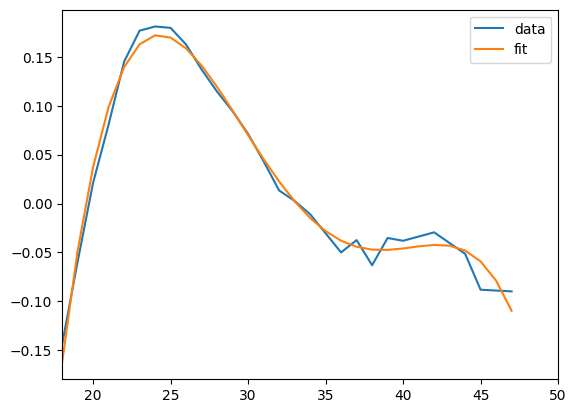

In [730]:
import matplotlib.pyplot as plt

ages = range(18, 48)
A = [-0.14396,-0.05957,0.021176,0.080782,0.144998,0.176731,
0.181012,0.179595,0.162485,0.137085,0.114395,0.094328,
0.071203,0.043198,0.013411,0.002706,-0.01087,-0.030415,
-0.04996,-0.03732,-0.06303,-0.03521,-0.038033904,-0.033721952,
-0.02941,-0.04036,-0.05131,-0.08806,-0.08892,-0.08978]
poly  = np.polyfit(ages, A, 4)
fig, ax = plt.subplots()
ax.plot(ages, A, label='data')
ax.plot(ages, np.polyval(poly, ages), label='fit')
ax.set_xlim(18, 50)
ax.legend()
np.polyval(poly, 20.2)

In [167]:
trainset.groupby(['Player']).var()['Projection'].mean()

C:\Users\jetso\AppData\Local\Temp\ipykernel_368\1148530922.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



0.03676015491816453

In [24]:
df, df1 = get_projections('Auston Matthews', 'Career Game')

100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


In [39]:

sensor_var = 1.3330171065772254
process_var = 0.0013513089896074557
process_model = gaussian(0., process_var)
pos = gaussian(0., 100.)
N = len(df) + 20
zs = np.concatenate((np.zeros(20), df['Score'].to_list()))
ps = []
for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

ps[30:]

[0.35461799646405234,
 0.35223578154649926,
 0.2815646748047127,
 0.32871139753144757,
 0.32309581754859984,
 0.2898585146781473,
 0.33586485674755534,
 0.3371465637863367,
 0.35509624013546953,
 0.42448362545749196,
 0.45829446268339136,
 0.39285789062227316,
 0.43947560991193757,
 0.4482023309264871,
 0.5082195464868176,
 0.5135082611204419,
 0.5715263682478999,
 0.5629235996830103,
 0.5539283406397204,
 0.5843378603005317,
 0.6009595683039096,
 0.6098171733964084,
 0.6921346177543615,
 0.76146397568514,
 0.8018198802080968,
 0.8292026291072654,
 0.8113833811788366,
 0.7831552734538604,
 0.7764010218074291,
 0.7331505670750138,
 0.7539293890257848,
 0.6796554779722391,
 0.6503874299106893,
 0.6457831221779434,
 0.692749669067777,
 0.60995752030963,
 0.6340355248978818,
 0.5696059565863678,
 0.6513055461538418,
 0.6311399626670817,
 0.6527551860373028,
 0.5802408196487776,
 0.5626180223766521,
 0.6491513031072995,
 0.6600798563464638,
 0.7091734477797729,
 0.7517191851919196,
 0.77636